# Determining null size for mAP p-value calculation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import comb

from copairs import map

In [2]:
def plot_scatter_grid(
    data,
    null_size_col="null_size",
    x_col="mAP",
    y_col="-log10(p-value)",
    color_col="below_corrected_p",
    cmap="tab10",
    figsize=(12, 6),
):
    """Plot a grid of scatter plots for different values of a given column.

    Args:
        data (pd.DataFrame): Input DataFrame containing the data.
        null_size_col (str): Column to split data into subplots. Defaults to "null_size".
        x_col (str): Column to use for the x-axis. Defaults to "mean_average_precision".
        y_col (str): Column to use for the y-axis. Defaults to "-log10(p-value)".
        color_col (str): Column for coloring points. Defaults to "below_corrected_p".
        cmap (str): Colormap for the scatter plot. Defaults to "tab10".
        figsize (tuple): Figure size. Defaults to (12, 6).
    """
    unique_null_sizes = sorted(data[null_size_col].unique())  # Get unique values
    n_rows, n_cols = 3, 4  # Define grid shape

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten for easy iteration

    for i, null_size in enumerate(unique_null_sizes):
        ax = axes[i]
        subset = data[data[null_size_col] == null_size]  # Filter data for current panel

        # Compute active ratio for the subset
        active_ratio = subset[color_col].mean()

        # Scatter plot
        _ = ax.scatter(
            subset[x_col], subset[y_col], c=subset[color_col], cmap=cmap, s=10
        )

        ax.axhline(
            -np.log10(0.05), color="black", linestyle="--"
        )  # Significance threshold
        ax.set_title(f"{null_size_col} = {null_size}")

        # Display active ratio per panel
        ax.text(
            0.4,
            5,
            f"Active = {100 * active_ratio:.2f}%",
            va="center",
            ha="left",
            fontsize=9,
        )

        if i % n_cols == 0:  # Leftmost column
            ax.set_ylabel(y_col)
        if i >= (n_rows - 1) * n_cols:  # Bottom row
            ax.set_xlabel(x_col)

    fig.suptitle(f"Scatter plots across different {null_size_col} values", fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout
    plt.show()

## Load data

This example relies on data and results from the [Phenotypic activity](./phenotypic_activity.ipynb) example, so run that one first if you haven't.

Let's define some helper functions.

In [3]:
df_activity = pd.read_csv("data/2016_04_01_a549_48hr_batch1_plateSQ00014812.csv")
activity_ap = pd.read_csv("data/activity_ap.csv")

## Complete null size

We estimate the statistical significance of a mAP score with respect to a random baseline using a permutation testing approach, a non-parametric, assumption-free method for testing the null hypothesis of sample exchangeability. The complete AP null distribution consists of all possible rank list re-shuffles.

Let $m$ to be the number of perturbation replicates and $n$ to be the number of control profiles. Given that one perturbation profile serves as a query, the complete null size $d$ can be calculated as a binomial coefficient:

\begin{equation}
    d_{null} = \binom{(m-1)}{(m-1)*n}
\end{equation}

Let's calculate the complete null size for the example dataset.

In [4]:
# almost all perturbations have 6 replicates
m = (
    df_activity.query("Metadata_broad_sample != 'DMSO'")
    .groupby("Metadata_broad_sample")
    .size()
    .mode()[0]
)
# the number of control profiles is 24
n = df_activity.query("Metadata_broad_sample == 'DMSO'").shape[0]

# using SciPy's comb function for numerical stability
d = comb(m - 1 + n, m - 1, exact=True)

print(f"{m=}, {n=}, {d=}")

m=6, n=24, d=118755


For large datasets, computing the full combinatorial null is infeasible. Instead, we approximate the null distribution using Monte Carlo sampling with $d_{\text{perm}}$ permutations:

\begin{equation}
    null\_size \approx d_{null}
\end{equation}

where $null\_size$ is the number of random rank list shufflings applied to estimate the null distribution.

## Effect of null size on mAP p-value calculation

Let's calculate mAP significance on the given dataset using `null_size` values from $10$ to $5*10^6$ and plot results below.

We'll also change the location of cached null distributions from user home to a local subdiretory.

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

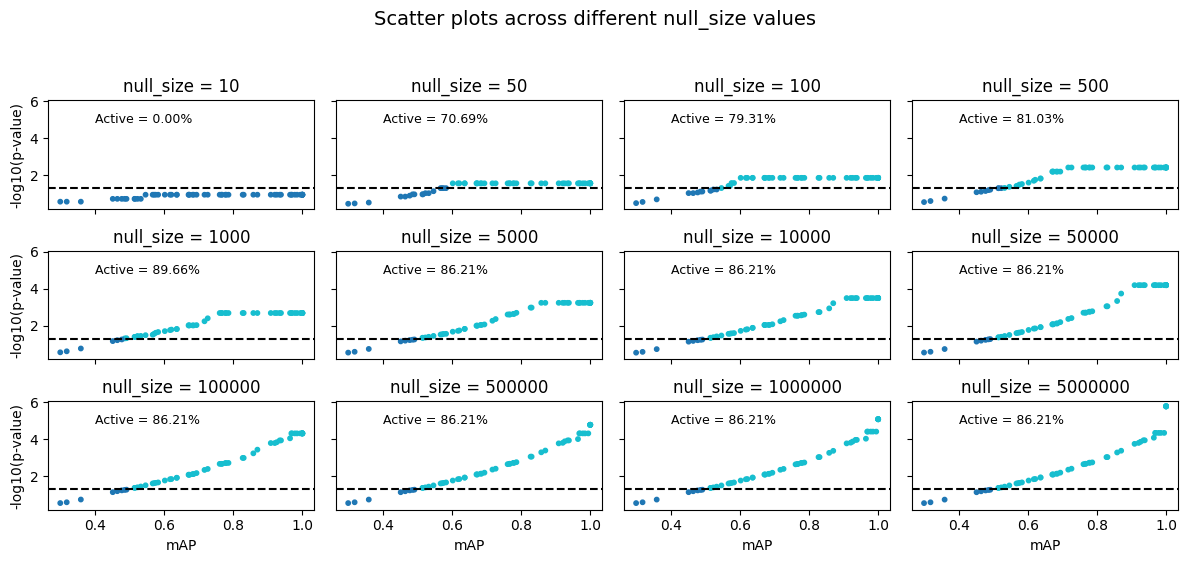

In [5]:
seed = 0
null_cache_dir = "cache"  # default is Path.home() / ".copairs"

activity_maps = []
for ns_pow in range(1, 7):
    null_size = 10**ns_pow

    replicate_map = map.mean_average_precision(
        activity_ap,
        ["Metadata_broad_sample"],
        null_size=null_size,
        threshold=0.05,
        seed=seed,
        cache_dir=null_cache_dir,
    )
    replicate_map["null_size"] = null_size
    activity_maps.append(replicate_map)

    replicate_map = map.mean_average_precision(
        activity_ap,
        ["Metadata_broad_sample"],
        null_size=5 * null_size,
        threshold=0.05,
        seed=seed,
        cache_dir=null_cache_dir,
    )
    replicate_map["null_size"] = 5 * null_size
    activity_maps.append(replicate_map)

activity_maps = pd.concat(activity_maps)
activity_maps.rename(columns={"mean_average_precision": "mAP"}, inplace=True)
activity_maps["-log10(p-value)"] = -activity_maps["corrected_p_value"].apply(np.log10)

plot_scatter_grid(activity_maps)

Because the full null size $d_{null}=118755$, smaller sample sizes ($<=1,000$) lead to poor estimation of significance for these data, while very large values ($>100,000$) cover the whole null and do not affect perturbation ranking results.

## Practical consideration for choosing the null size

In practice, drawing a large number of samples is not always feasible, because compute time for each AP calculation grows with the higher number of perturbations of the dataset, the number of metadata constraints for profile grouping, sizes of perturbation groups (the number of perturbation replicates) and control groups (the number of control replicates), and profile dimensionality (the number of features in a profile).

Finding a `null_size` that works for a particular dataset means balancing between test resolution (for example, being able to tell apart vary small p-values) and compute. We provided `null_size` values for each real-world dataset in Supplemental Materials to our paper—please refer to:

> Kalinin, A. A. et al. A versatile information retrieval framework for evaluating profile strength and similarity. bioRxiv, 2024-04, (2024).